In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from xgboost import XGBRegressor

In [90]:
data = pd.read_csv('processed_data_by_property.csv')

In [91]:
target = 'PRICE'

In [92]:
# Define features
categorical_features = ['TYPE', 'ZIPCODE', 'BOROUGH']
numeric_features = ['BEDS', 'BATH', 'PROPERTYSQFT', 'Population', 'LivelinessScore', 'LATITUDE', 'LONGITUDE', 'MedianHouseholdIncome', 'PopulationDensity']

In [93]:
X = data.drop(columns=[target])
y = data[target]

In [94]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [95]:
xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

In [96]:
# Split the data and train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
xgb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['BEDS', 'BATH',
                                                   'PROPERTYSQFT', 'Population',
                                                   'LivelinessScore',
                                                   'LATITUDE', 'LONGITUDE',
                                                   'MedianHouseholdIncome',
                                                   'PopulationDensity']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['TYPE', 'ZIPCODE',
                                                   'BOROUGH'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=Non...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [98]:
# Calculate performance metrics
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

In [99]:
# Training set metrics
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

# Test set metrics
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Calculate MAE as a percentage
avg_train_price = y_train.mean()
avg_test_price = y_test.mean()
train_mae_percent = (train_mae / avg_train_price) * 100
test_mae_percent = (test_mae / avg_test_price) * 100

In [100]:
print("Training Set Metrics:")
print(f"R2 Score: {train_r2:.4f}")
print(f"MAE: ${train_mae:,.2f} ({train_mae_percent:.2f}%)")
print(f"RMSE: ${train_rmse:,.2f}")
print(f"MAPE: {train_mape:.2f}%")

Training Set Metrics:
R2 Score: 0.9003
MAE: $135,248.96 (14.66%)
RMSE: $201,953.12
MAPE: 18.09%


In [101]:
print("\nTest Set Metrics:")
print(f"R2 Score: {test_r2:.4f}")
print(f"MAE: ${test_mae:,.2f} ({test_mae_percent:.2f}%)")
print(f"RMSE: ${test_rmse:,.2f}")
print(f"MAPE: {test_mape:.2f}%")


Test Set Metrics:
R2 Score: 0.7420
MAE: $201,440.22 (22.36%)
RMSE: $310,155.22
MAPE: 26.88%


In [102]:
# Save the model
joblib.dump(xgb_model, 'xgb_model_features.joblib')

['xgb_model_features.joblib']

In [103]:
cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R2 Scores: {cv_scores}")
print(f"Mean CV R2 Score: {np.mean(cv_scores)}")

Cross-Validation R2 Scores: [0.66725314 0.75541331 0.76930597 0.76045632 0.74091899]
Mean CV R2 Score: 0.7386695462384203


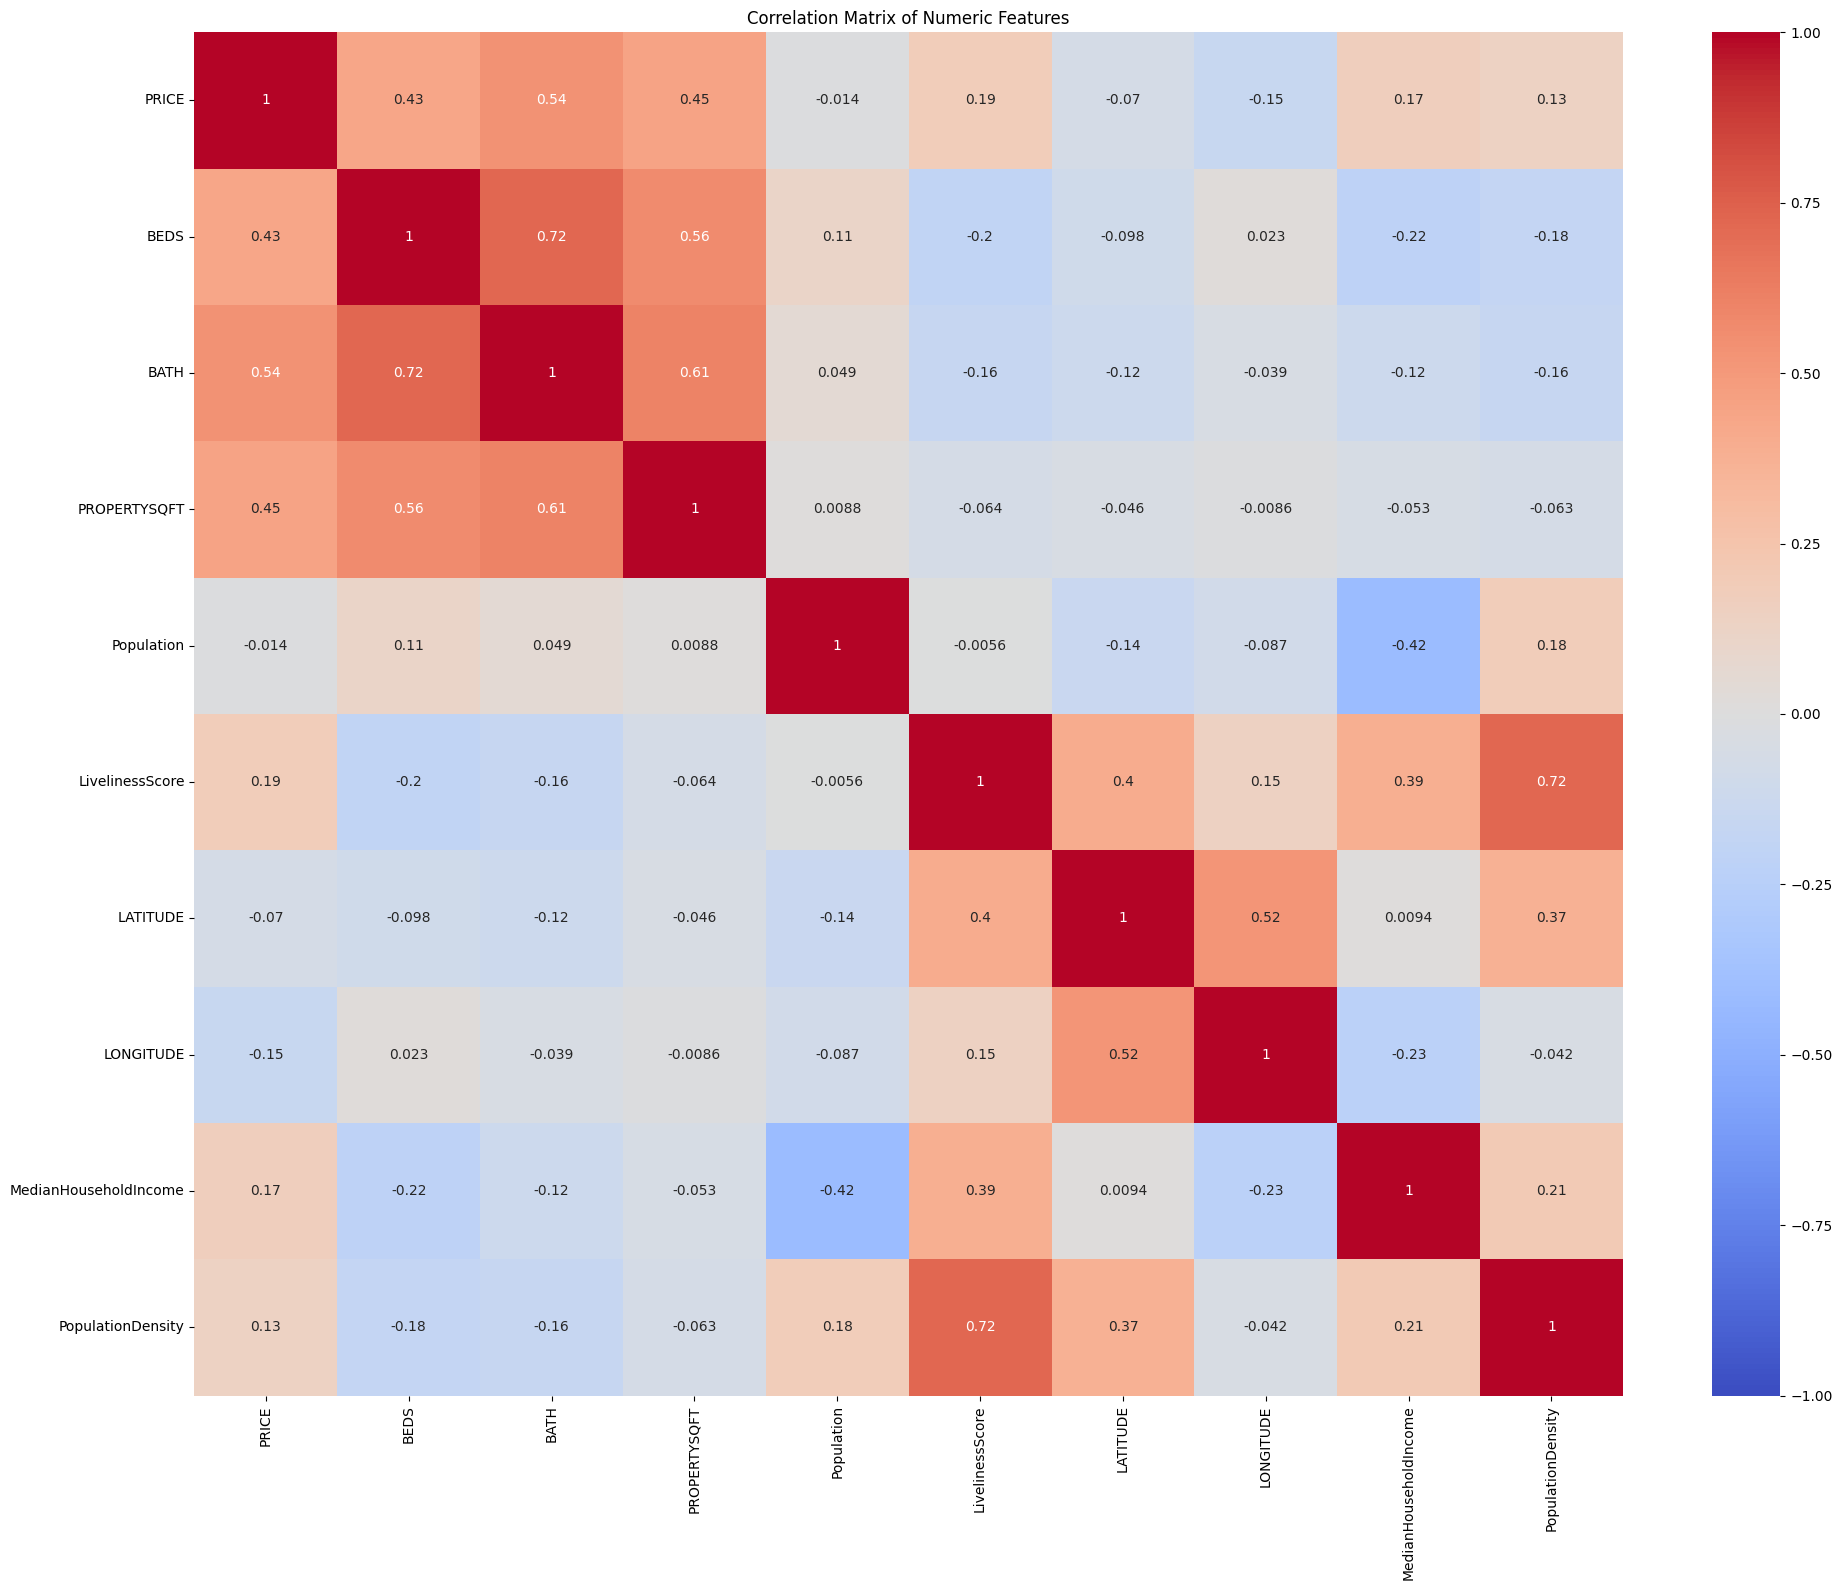

Correlations with PRICE:
PRICE                    1.000000
BATH                     0.536103
PROPERTYSQFT             0.451598
BEDS                     0.433762
LivelinessScore          0.185070
MedianHouseholdIncome    0.170898
PopulationDensity        0.134946
Population              -0.013545
LATITUDE                -0.069865
LONGITUDE               -0.152037
Name: PRICE, dtype: float64


In [104]:
# Select numeric columns for correlation matrix
numeric_cols = ['PRICE'] + numeric_features 

# Calculate the correlation matrix
corr_matrix = data[numeric_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

# %%
# Print correlations with the target variable (PRICE)
price_correlations = corr_matrix['PRICE'].sort_values(ascending=False)
print("Correlations with PRICE:")
print(price_correlations)

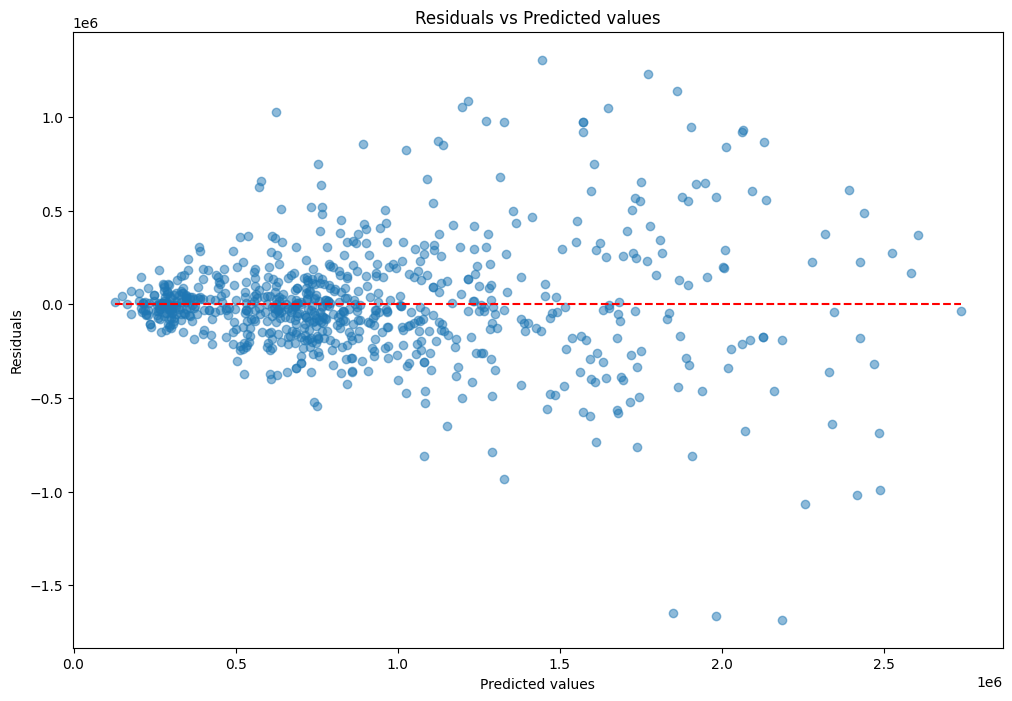

In [105]:
# Calculate residuals
residuals = y_test - y_test_pred

# Plot residuals vs predicted values
plt.figure(figsize=(12, 8))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_test_pred.min(), xmax=y_test_pred.max(), colors='red', linestyles='dashed')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values')
plt.show()

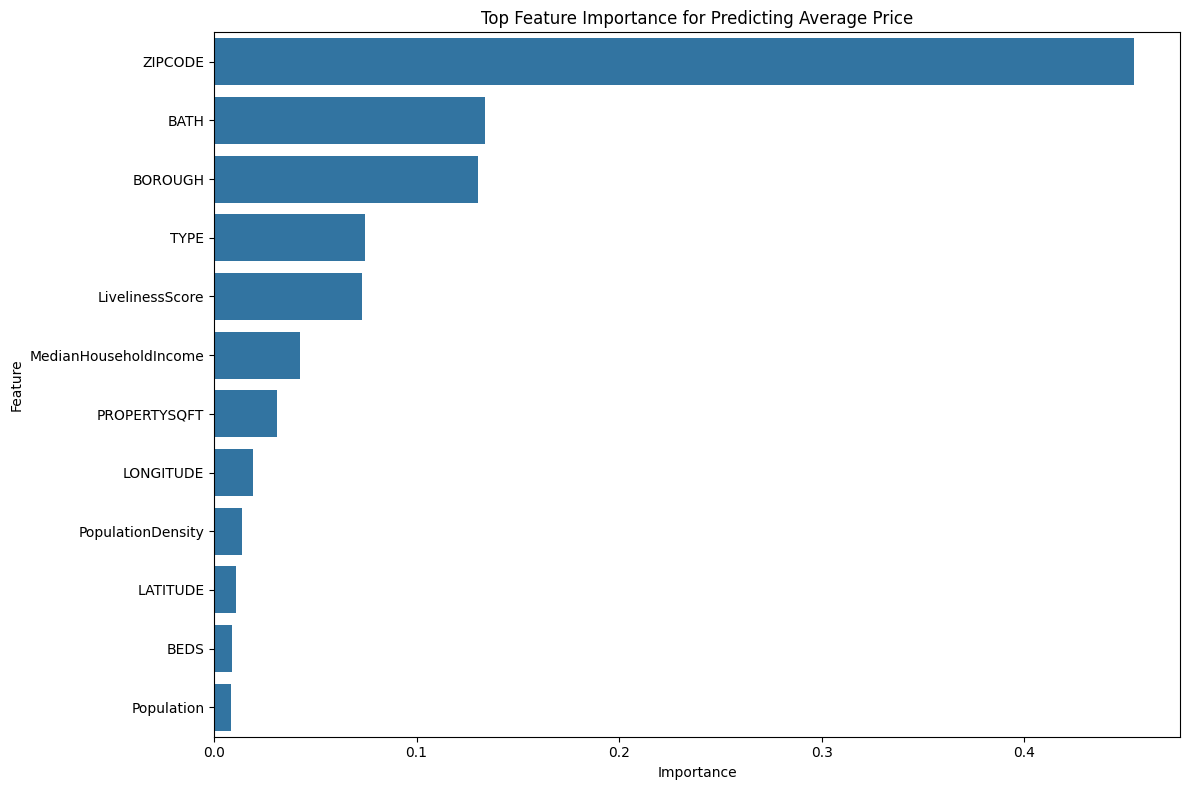

In [106]:
# Get feature names
numeric_features_names = numeric_features
categorical_features_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.array(numeric_features_names + list(categorical_features_names))

# Get feature importances from the XGBoost model
importances = xgb_model.named_steps['regressor'].feature_importances_

# Aggregate importances for categorical variables
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance['feature'] = feature_importance['feature'].apply(lambda x: x.split('_')[0] if '_' in x else x)
feature_importance = feature_importance.groupby('feature').sum().reset_index()
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Plot top feature importances
top_n = min(20, len(feature_importance))
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(top_n))
plt.title('Top Feature Importance for Predicting Average Price')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [107]:
# Print feature importances
print("Feature Importances:")
print(feature_importance)

Feature Importances:
                  feature  importance
11                ZIPCODE    0.454148
0                    BATH    0.133778
2                 BOROUGH    0.130193
10                   TYPE    0.074676
5         LivelinessScore    0.072999
6   MedianHouseholdIncome    0.042422
7            PROPERTYSQFT    0.030928
4               LONGITUDE    0.019088
9       PopulationDensity    0.013616
3                LATITUDE    0.010984
1                    BEDS    0.008639
8              Population    0.008530


## Test against linear regression

In [108]:
baseline_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
baseline_model.fit(X_train, y_train)
y_test_baseline_pred = baseline_model.predict(X_test)
baseline_r2 = r2_score(y_test, y_test_baseline_pred)
print(f"Baseline Linear Regression R2 Score: {baseline_r2:.4f}")

Baseline Linear Regression R2 Score: 0.5609


## Test Query to see performance - poor performance

In [109]:
def get_top_zipcodes(borough, max_price, house_type, bedrooms, bathrooms, sqft, model, data, categorical_features, numeric_features):
    # Filter data for the specified borough first
    borough_data = data[data['BOROUGH'] == borough].copy()
    
    # Prepare input data for prediction
    borough_data['TYPE'] = house_type
    borough_data['BEDS'] = bedrooms
    borough_data['BATH'] = bathrooms
    borough_data['PROPERTYSQFT'] = sqft
    borough_data['PRICE_PER_SQFT'] = max_price / sqft  
    
    # Select only the required features
    input_data = borough_data[categorical_features + numeric_features]
    
    # Predict prices
    predicted_prices = model.predict(input_data)
    input_data['PredictedPrice'] = predicted_prices
    
    # Filter and sort by price
    filtered_data = input_data[input_data['PredictedPrice'] <= max_price]
    
    # Drop duplicates based on the ZIPCODE column
    filtered_data = filtered_data.drop_duplicates(subset='ZIPCODE')
    
    # Select the top 20 zip codes by predicted price
    top_zipcodes = filtered_data[['ZIPCODE', 'PredictedPrice']].nlargest(5, 'PredictedPrice')
   
    return top_zipcodes

# Example query (keep this part the same)
query_params = {
    'borough': 'Brooklyn',
    'max_price': 1000000,
    'house_type': 'House',
    'bedrooms': 2,
    'bathrooms': 1,
    'sqft': 1000,
}

top_zipcodes = get_top_zipcodes(
    borough=query_params['borough'],
    max_price=query_params['max_price'],
    house_type=query_params['house_type'],
    bedrooms=query_params['bedrooms'],
    bathrooms=query_params['bathrooms'],
    sqft=query_params['sqft'],
    model=xgb_model,
    data=data,
    categorical_features=categorical_features,
    numeric_features=numeric_features
)

print("Top 20 zip codes by predicted price:")
print(top_zipcodes)

Top 20 zip codes by predicted price:
      ZIPCODE  PredictedPrice
719     11201     999521.0625
132     11215     997184.5000
1822    11222     989729.3125
2516    11211     970928.5000
13      11209     962049.3125


C:\Users\simon\AppData\Local\Temp\ipykernel_7668\2198102760.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['PredictedPrice'] = predicted_prices
